<a href="https://colab.research.google.com/github/Saif-M-Dhrubo/AI-Lab/blob/master/AI_FinalASS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/jhyuklee/ethnicity-tensorflow

Cloning into 'ethnicity-tensorflow'...
remote: Enumerating objects: 80, done.
remote: Total 80 (delta 0), reused 0 (delta 0), pack-reused 80
Unpacking objects: 100% (80/80), done.


In [2]:
cd ethnicity-tensorflow

/content/ethnicity-tensorflow


In [0]:
from __future__ import absolute_import

import os
import re

import numpy as np


def get_ethnicity_data(data_dir, params):
    is_ethnicity = params['ethnicity']

    for root, dir, files in os.walk(data_dir):
        unigram_set = []
        bigram_set = []
        trigram_set = []
        length_set = []
        labels = []

        unigram2idx = {}
        idx2unigram = {}
        bigram2idx = {}
        idx2bigram = {}
        trigram2idx = {}
        idx2trigram = {}
        country2idx = {}
        idx2country = {}
        country2ethnicity = {}
        name_max_len = 0

        train_set = []
        valid_set = []
        test_set = []

        for file_cnt, file_name in enumerate(sorted(files)):
            data = open(os.path.join(root, file_name))
            file_len = 0

            if file_name == '0_unigram_to_idx.txt':
                for k, line in enumerate(data):
                    file_len = k + 1
                    unigram, index = line[:-1].split('\t')
                    unigram2idx[unigram] = int(index)
                    idx2unigram[int(index)] = unigram
            elif file_name == '1_bigram_to_idx.txt':
                for k, line in enumerate(data):
                    file_len = k + 1
                    bigram, index = line[:-1].split('\t')
                    bigram2idx[bigram] = int(index)
                    idx2bigram[int(index)] = bigram
            elif file_name == '2_trigram_to_idx.txt':
                for k, line in enumerate(data):
                    file_len = k + 1
                    trigram, index = line[:-1].split('\t')
                    trigram2idx[trigram] = int(index)
                    idx2trigram[int(index)] = trigram
            elif file_name == 'country_to_idx.txt':
                for k, line in enumerate(data):
                    file_len = k + 1
                    country, index = line[:-1].split('\t')
                    if not is_ethnicity:
                        index = k  # Change to index when testing nationality
                    country2idx[country] = int(index)
                    idx2country[int(index)] = country
            elif file_name == 'country_to_ethnicity.txt':
                for k, line in enumerate(data):
                    file_len = k + 1
                    country, eth1, eth2 = line[:-1].split('\t')
                    country2ethnicity[int(country)] = [int(eth1), int(eth2)]
            elif 'data_' in file_name:
                for k, line in enumerate(data):
                    name, nationality = line[:-1].split('\t')
                    name = re.sub(r'\ufeff', '', name)  # delete BOM

                    unigram_vector = [unigram2idx[c] if c in unigram2idx else 0 for c in name]
                    bigram_vector = [bigram2idx[c1 + c2] if (c1 + c2) in bigram2idx else 0
                                     for c1, c2 in zip(*[name[i:] for i in range(2)])]
                    trigram_vector = [trigram2idx[c1 + c2 + c3] if (c1 + c2 + c3) in trigram2idx else 0
                                      for c1, c2, c3 in zip(*[name[i:] for i in range(3)])]

                    # label vector
                    nationality = country2idx[nationality]
                    if is_ethnicity:
                        ethnicity = country2ethnicity[nationality][1]
                        if ethnicity < 0:
                            continue
                    name_length = len(name)

                    if name_max_len < len(name):
                        name_max_len = len(name)

                    unigram_set.append(unigram_vector)
                    bigram_set.append(bigram_vector)
                    trigram_set.append(trigram_vector)
                    length_set.append(name_length)
                    if is_ethnicity:
                        labels.append(ethnicity)
                    else:
                        labels.append(nationality)
                    file_len = k + 1

                if 'train_ch' in file_name:
                    train_set = [unigram_set, bigram_set, trigram_set, length_set, labels]
                elif 'val' in file_name:
                    valid_set = [unigram_set, bigram_set, trigram_set, length_set, labels]
                elif 'ijcai' in file_name:  # test
                    test_set = [unigram_set, bigram_set, trigram_set, length_set, labels]
                else:
                    assert True, 'not allowed file name %s' % file_name

                unigram_set = []
                bigram_set = []
                trigram_set = []
                length_set = []
                labels = []
            else:
                print('ignoring file', file_name)

            print('reading', file_name, 'of length', file_len)

    print('total data length:', len(train_set[0]), len(valid_set[0]), len(test_set[0]))
    print('shape of data:', np.array(train_set).shape, np.array(valid_set).shape, np.array(test_set).shape)
    print('name max length:', name_max_len)
    #print('Train Set : ', train_set)
    #print('Validation Set : ', valid_set)
    #print('Test Set : ', test_set)

    return (train_set, valid_set, test_set,
            [idx2unigram, unigram2idx, idx2country, country2ethnicity, idx2bigram, idx2trigram])


In [4]:
import gensim


data_dir = './data/raw'
params = {'ethnicity': False}
train_set, valid_set, test_set, dictionary = get_ethnicity_data(data_dir, params)
vec = 2
dic = 5

sentences = []
for sentence in train_set[vec][:]:
    char_seq = [dictionary[dic][c] for c in sentence]
    sentences.append(char_seq)
for sentence in valid_set[vec][:]:
    char_seq = [dictionary[dic][c] for c in sentence]
    sentences.append(char_seq)
for sentence in test_set[vec][:]:
    char_seq = [dictionary[dic][c] for c in sentence]
    sentences.append(char_seq)

model = gensim.models.Word2Vec(sentences, size=100, window=5, min_count=0, iter=100)

for alphabet in dictionary[dic].values():
    print('most similar to', alphabet, end=' is ')
    try:
        print(' '.join([(s) for s, _ in model.most_similar(positive=[alphabet], topn=10)]))
    except:
        print('no values', alphabet)

paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress


reading 0_unigram_to_idx.txt of length 82
reading 1_bigram_to_idx.txt of length 1876
reading 2_trigram_to_idx.txt of length 14767
reading country_to_ethnicity.txt of length 127
reading country_to_idx.txt of length 127
reading data_ijcai_authors of length 2408
reading data_raw_test of length 3543
reading data_raw_train of length 10633
reading data_raw_train_ch of length 10754
reading data_raw_valid of length 3545
total data length: 10754 3545 2408
shape of data: (5, 10754) (5, 3545) (5, 2408)
name max length: 47
most similar to   B is rui  Gu ask  Wa Zha  Ga Min  Ti hou Xia
most similar to   H is no values   H
most similar to   M is e   .D. C.J F.D T.E .E. E.J Pee L.F CMI
most similar to   R is n   EDG RED DDO MFR DWO n R EMF p R DGR
most similar to  "F is "Fi a " eia Fil Zia Zof aia fia lo" zia
most similar to  "H is "Ha n " rro Nix arr ixo Ego Leb rry xon
most similar to  "L is e " "Le "Li ni" i"  " S na" Zin a"  Fin
most similar to  "O is "Ol f " Oll le" e"  " A  Mö lle öll Möl
most 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):



most similar to  Em is Emi mil Yum Boh ilc hil yud ile eil lce
most similar to  En is Eng nge gel Ang Ing End -In geu r-I  Ly
most similar to  Ep is Eph rfr Nya Hed Geh rai Usa oci Si  ÖNE
most similar to  Er is Erh Erk Ern kle rne nes s E scu Eri -Er
most similar to  Es is wsk Ess Ida z E ews Mut taz gal ukh Muk
most similar to  Et is Eti Xen ryv Met Ail yvo Nac Piu eez GEV
most similar to  Eu is Eug uge Jér uze ugè örj gèn ken Eus Eur
most similar to  Ev is Eve ver w E rts etm rtt om  cks tma Rup
most similar to  Ew is no values  Ew
most similar to  F. is F.  . F .F. R.A O.W L.F W.F F.L F.D . P
most similar to  FA is FAB FAR FAL FAS FAI FAT FAH C F FAC HRN
most similar to  FE is FER ÖFE -FE HÖF PFE HÄF IFE FED N-F FEN
most similar to  FF is FFR Non -SO Nac oci DRS AFR UHY Ink RÄN
most similar to  FI is FIS FIL FIU FIV y F A F FIN ILH FID FIO
most similar to  FL is FLO FLA FLE FLU ODQ FLI x F d F ) F p F
most similar to  FO is FOR FON FOU NDF ÄND FOX KIF FOS LFO FOO
most similar to  

In [11]:
dictionary[5][6]

' "L'

In [6]:
print(train_set)

[[[8, 45, 38, 57, 0, 14, 16, 22, 25, 14, 12, 27, 27, 16], [17, 79, 51, 40, 38, 47, 0, 0, 9, 48, 43, 52, 38, 47, 0, 20, 70, 19, 19, 12, 25], [27, 34, 53, 58, 34, 47, 34, 0, 29, 12, 16, 21, 9, 12, 25, 14, 8], [32, 48, 54, 47, 40, 5, 8, 41, 0, 14, 16, 19], [21, 42, 44, 48, 45, 34, 48, 52, 0, 18, 8, 18, 19, 8, 20, 8, 21, 8, 18, 16, 26], [18, 42, 51, 44, 0, 23, 8, 19, 20, 12, 25], [21, 34, 37, 38, 59, 41, 37, 34, 0, 19, 16, 28, 9, 16, 20, 22, 29, 8], [12, 45, 38, 47, 34, 0, 25, 22, 20, 8, 21, 22, 29, 8], [26, 34, 47, 40, 5, 12, 54, 47, 0, 22, 15], [19, 54, 36, 42, 34, 0, 20, 22, 25, 16, 10, 22], [17, 48, 52, 38, 49, 41, 0, 9, 8, 25, 27, 15, 12, 19], [9, 38, 55, 38, 51, 45, 38, 58, 0, 17, 48, 58, 0, 30, 15, 16, 27, 13, 16, 12, 19, 11], [14, 38, 46, 46, 34, 0, 9, 12, 8, 11, 26, 30, 22, 25, 27, 15], [27, 48, 47, 38, 0, 15, 8, 28, 14, 12, 21], [29, 45, 34, 52, 53, 42, 35, 48, 51, 0, 18, 22, 21, 12, 10, 21, 32], [14, 34, 45, 42, 47, 34, 0, 33, 32, 9, 16, 21, 8], [8, 47, 34, 53, 48, 45, 42, 0, 20

In [7]:
print(valid_set)

[[[8, 58, 34, 59, 0, 20, 12, 15, 20, 22, 22, 11], [18, 41, 48, 51, 45, 48, 48, 0, 9, 8, 32, 8, 21, 20, 28, 21, 18], [30, 6, 0, 30, 8, 19, 16], [15, 38, 45, 40, 34, 0, 18, 19, 12, 16, 21], [26, 53, 38, 49, 41, 34, 47, 38, 0, 25, 16, 26, 8, 10, 15, 12, 25], [17, 48, 47, 34, 52, 0, 30, 8, 25, 25, 12, 25], [15, 34, 47, 52, 0, 9, 12, 27, 27, 12, 20, 9, 22, 28, 25, 14], [11, 38, 51, 38, 44, 0, 23, 22, 25, 27, 12, 25], [12, 55, 38, 51, 53, 0, 14, 28, 21, 21, 8, 25, 26, 26, 22, 21], [20, 42, 44, 34, 38, 45, 0, 20, 6, 0, 11, 22, 25, 16, 33, 8, 26], [14, 38, 48, 51, 40, 38, 0, 21, 16, 10, 22, 19], [15, 38, 45, 38, 47, 38, 0, 17, 28, 21, 18, 12, 25], [8, 41, 46, 38, 37, 0, 20, 28, 26, 15, 27, 8, 24], [20, 34, 51, 42, 48, 47, 0, 9, 12, 10, 18, 12, 25, 5, 26, 27, 12, 16, 21, 12, 25], [32, 47, 40, 55, 38, 0, 9, 25, 22, 11, 11], [21, 54, 51, 46, 34, 40, 48, 46, 38, 37, 0, 26, 15, 8, 21, 8, 29, 8, 33, 22, 29], [17, 48, 41, 47, 0, 15, 48, 56, 34, 51, 37, 0, 19, 12, 10, 22, 20, 23, 27, 12], [20, 58, 54,

In [8]:
word_vectors = model.wv
print("Number of word vectors: {}".format(len(word_vectors.vocab)))

[[[9, 34, 51, 53, 0, 9, 48, 40, 34, 38, 51, 53, 52], [19, 54, 42, 52, 0, 10, 51, 54, 59, 5, 13, 42, 45, 42, 49, 38], [17, 42, 34, 58, 42, 0, 20, 34], [17, 42, 0, 33, 41, 34, 48], [15, 34, 47, 50, 42, 0, 14, 54, 48], [17, 54, 47, 43, 54, 47, 0, 17, 42, 34, 47, 40], [15, 54, 34, 35, 42, 47, 40, 0, 33, 41, 48, 54], [32, 54, 34, 47, 0, 14, 34, 48], [9, 34, 51, 53, 0, 9, 48, 40, 34, 38, 51, 53, 52], [17, 48, 48, 52, 53, 0, 29, 38, 47, 47, 38, 44, 38, 47, 52], [20, 34, 51, 36, 0, 11, 38, 47, 38, 36, 44, 38, 51], [33, 41, 42, 58, 48, 47, 40, 0, 10, 41, 38, 47, 40], [17, 42, 34, 45, 42, 38, 0, 26, 41, 38, 47], [19, 38, 42, 0, 33, 41, 54], [20, 48, 41, 34, 47, 0, 18, 34, 47, 44, 34, 47, 41, 34, 45, 45, 42], [19, 42, 50, 42, 34, 47, 40, 0, 21, 42, 38], [19, 42, 34, 47, 40, 0, 31, 42, 38], [17, 42, 34, 45, 42, 38, 0, 26, 41, 38, 47], [17, 54, 47, 40, 48, 47, 40, 0, 15, 34, 47], [19, 38, 42, 0, 33, 41, 54], [19, 42, 47, 40, 0, 26, 41, 34, 48], [19, 38, 42, 45, 34, 0, 8, 20, 14, 22, 28, 11], [17, 4

In [45]:
word_vectors = model.wv
print("Number of word vectors: {}".format(len(word_vectors.vocab)))

Number of word vectors: 13926


In [46]:
len(word_vectors.vocab)

13926

In [56]:
model.wv[dictionary[5][0]]

array([ 0.9342211 , -3.1044638 , -0.46744663, -1.6733897 , -3.4906037 ,
       -0.3358961 , -0.17345968, -3.0936074 , -4.5143037 ,  0.14819479,
       -0.78208166, -1.3589057 , -1.5464557 ,  2.5870972 ,  1.024698  ,
       -3.8531373 , -0.3333757 ,  0.4681775 , -0.43554598, -1.7289732 ,
        0.55267423, -2.1059637 , -2.1212063 , -0.42472398, -0.5100736 ,
        0.6081734 , -1.4529706 , -1.1565185 , -0.53657174,  1.2688612 ,
       -2.6930344 ,  1.2455884 ,  2.519308  ,  0.43700132, -0.80255926,
        0.49062324, -3.9768996 ,  1.7507714 , -3.1588345 , -3.072153  ,
       -3.7023714 , -0.77722055, -0.54972833,  2.1201255 , -1.38538   ,
       -0.58565754,  5.8206387 ,  0.514846  , -1.5182915 , -1.7381635 ,
        0.37450883, -2.1389358 , -0.25103676,  2.4295285 , -3.0698512 ,
       -1.4884773 ,  0.8881939 ,  1.3855224 , -1.7237753 ,  0.85102475,
       -1.2711792 , -0.6135961 ,  0.38329452, -5.4578876 , -0.66526663,
       -1.8215736 ,  0.8316254 , -1.5273823 , -4.627862  , -1.12

In [63]:
WV_DIM = word_vectors.vector_size
nb_words = len(train_set[0])

print(nb_words, WV_DIM)
wv_matrix = np.random.rand(nb_words, WV_DIM)

    

10754 100


In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM

In [0]:
model = Sequential()
model.add(Embedding(nb_words, WV_DIM, trainable=False))
model.add(LSTM(100))
model.add(Dropout(0.0035))
model.add(Dense(1, activation='softmax'))

In [85]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 100)         1075400   
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 1,155,901
Trainable params: 80,501
Non-trainable params: 1,075,400
_________________________________________________________________


In [0]:
#from keras.utils import to_categorical

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [83]:
model.fit(train_set[3], train_set[4], batch_size=64, epochs=50)

10754/10754 [==============================] - 1s 73us/step - loss: nan - acc: 0.0099
Epoch 36/50
10754/10754 [==============================] - 1s 73us/step - loss: nan - acc: 0.0099
Epoch 37/50
10754/10754 [==============================] - 1s 71us/step - loss: nan - acc: 0.0099
Epoch 38/50
10754/10754 [==============================] - 1s 72us/step - loss: nan - acc: 0.0099
Epoch 39/50
10754/10754 [==============================] - 1s 72us/step - loss: nan - acc: 0.0099
Epoch 40/50
10754/10754 [==============================] - 1s 73us/step - loss: nan - acc: 0.0099
Epoch 41/50
10754/10754 [==============================] - 1s 75us/step - loss: nan - acc: 0.0099
Epoch 42/50
10754/10754 [==============================] - 1s 73us/step - loss: nan - acc: 0.0099
Epoch 43/50
10754/10754 [==============================] - 1s 73us/step - loss: nan - acc: 0.0099
Epoch 44/50
10754/10754 [==============================] - 1s 74us/step - loss: nan - acc: 0.0099
Epoch 45/50
10754/10754 [=======

In [84]:
scores = model.evaluate(test_set[3], test_set[4], verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

2408/2408 [==============================] - 0s 63us/step
Accuracy: 0.00%


In [86]:
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset but only keep the top n words, zero the rest
top_words = 5000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)
# truncate and pad input sequences
max_review_length = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, epochs=3, batch_size=64)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

17465344/17464789 [==============================] - 0s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
25000/25000 [==============================] - 278s 11ms/step - loss: 0.4965 - acc: 0.7632
Epoch 2/3
25000/25000 [==============================] - 276s 11ms/step - loss: 0.3573 - acc: 0.8528
Epoch 3/3
25000/25000 [==============================] - 274s 11ms/step - loss: 0.2929 - acc: 0.8824
Accuracy: 86.92%


In [1]:
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset but only keep the top n words, zero the rest
top_words = 5000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)
# truncate and pad input sequences
max_review_length = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, epochs=3, batch_size=64)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Using TensorFlow backend.


17465344/17464789 [==============================] - 0s 0us/step
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Use tf.cast instead.
Epoch 1/3
25000/25000 [==============================] - 353s 14ms/step - loss: 0.4998 - acc: 0

In [16]:
cd ..

/content


In [17]:
ls

data.zip  ethnicity-tensorflow/  sample_data/


In [18]:
!unzip data.zip

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  inflating: data/names/Japanese.txt  
  inflating: data/names/Korean.txt   
  inflating: data/names/Polish.txt   
  inflating: data/names/Portuguese.txt  
  inflating: data/names/Russian.txt  
  inflating: data/names/Scottish.txt  
  inflating: data/names/Spanish.txt  
  inflating: data/names/Vietnamese.txt  


In [19]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Vietnamese.txt', 'data/names/English.txt', 'data/names/Chinese.txt', 'data/names/French.txt', 'data/names/Japanese.txt', 'data/names/Greek.txt', 'data/names/Spanish.txt', 'data/names/Scottish.txt', 'data/names/German.txt', 'data/names/Italian.txt', 'data/names/Korean.txt', 'data/names/Irish.txt', 'data/names/Czech.txt', 'data/names/Polish.txt', 'data/names/Dutch.txt', 'data/names/Arabic.txt', 'data/names/Russian.txt', 'data/names/Portuguese.txt']
Slusarski


In [20]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [21]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [0]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [0]:
input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [24]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8451, -2.9444, -2.8584, -2.8084, -2.9602, -2.9220, -2.8967, -2.8718,
         -2.7714, -2.9263, -2.8739, -2.9376, -2.8702, -2.9472, -2.8814, -2.9664,
         -2.8272, -2.9451]], grad_fn=<LogSoftmaxBackward>)


In [26]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('German', 8)


In [27]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Italian / line = De felice
category = Portuguese / line = Ramires
category = Dutch / line = Ramaaker
category = Scottish / line = Lindsay
category = Scottish / line = Simpson
category = Korean / line = Jung 
category = Greek / line = Gravari
category = Polish / line = Bobienski
category = Japanese / line = Shimakage
category = Russian / line = Veselkov


In [0]:
criterion = nn.NLLLoss()

In [0]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [30]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 5s) 2.7302 Vicario / Portuguese ✗ (Italian)
10000 10% (0m 10s) 2.5980 Zhilkin / Irish ✗ (Russian)
15000 15% (0m 16s) 0.9144 Dan / Chinese ✓
20000 20% (0m 21s) 1.9948 Nowak / Arabic ✗ (Polish)
25000 25% (0m 26s) 2.1717 Quinones / Portuguese ✗ (Spanish)
30000 30% (0m 31s) 1.1552 Lac / Chinese ✗ (Vietnamese)
35000 35% (0m 37s) 1.6413 Venn / Chinese ✗ (Dutch)
40000 40% (0m 42s) 0.5739 Achthoven / Dutch ✓
45000 45% (0m 47s) 0.7562 Dagher / Arabic ✓
50000 50% (0m 53s) 1.6319 You / Korean ✗ (Chinese)
55000 55% (0m 59s) 1.6078 Hor / Korean ✗ (Chinese)
60000 60% (1m 4s) 0.1893 Nassar / Arabic ✓
65000 65% (1m 9s) 0.2529 Ruzanov / Russian ✓
70000 70% (1m 14s) 0.6332 Castro / Portuguese ✓
75000 75% (1m 19s) 1.0661 Jeon / Korean ✓
80000 80% (1m 24s) 3.2534 Schubert / German ✗ (Czech)
85000 85% (1m 29s) 4.3420 Leach / Vietnamese ✗ (English)
90000 90% (1m 34s) 0.2012 Vinci / Italian ✓
95000 95% (1m 39s) 0.8169 Gordon / Scottish ✓
100000 100% (1m 44s) 0.9469 Svotchak / Czech ✓


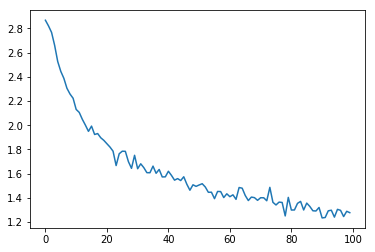

In [31]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

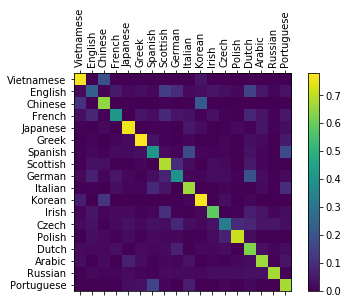

In [32]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [33]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.83) Czech
(-1.01) Russian
(-2.14) English

> Jackson
(-0.18) Scottish
(-2.37) English
(-3.83) Russian

> Satoshi
(-0.74) Japanese
(-1.56) Italian
(-2.54) Arabic
